# MNIST handwritten digits recognition
Written by Yujun Lin

## Preparation
Follow the instructions on notebook for training a binary single-layer perception and saving weights and images to local file.

change `image_id` for other pictures. There are 10 pictures in total, numbered from 0 to 9.

change `filename` to the name of file containing weights and images.

In [1]:
image_id = 7
filename = 'BNN.pkl'

## Preview the image of digit

To have a look at the image to be recognized on icestick

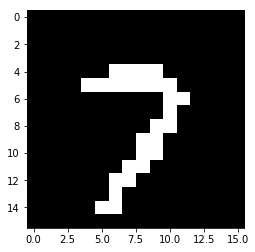

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open(filename, 'rb') as input_file:
    checkpoint = pickle.load(input_file)
imgs = checkpoint['imgs']

def display_img(index):
    img = imgs[:, index]
    img = np.reshape(img, [16, 16])
    plt.imshow(img, cmap='gray')
    plt.show()

display_img(image_id)

Rewrite script for new `image_id` and `filename`

In [3]:
with open('modules.py', 'r') as m, open('pipeline.py', 'w') as p:
    for line in m:
        if line.startswith('image_id = '):
            p.write('image_id = {}\n'.format(image_id))
        elif line.startswith('file_name = '):
            p.write('filename = \'{}\''.format(filename))
        else:
            p.write(line)

## Compile

we can use the magma binary to compile `nn.py` for the icestick

In [4]:
!../../bin/magma -b icestick nn.py

import mantle lattice ice40
import mantle lattice mantle40
compiling FullAdder
compiling AdderCout4
compiling Register4
compiling Counter4
compiling Adder4
compiling Register4R
compiling Register4CE
compiling Cascade4x2_2
compiling Controller
compiling ReadRom
compiling Register24
compiling NXor2x16
compiling BitCounter4
compiling HalfAdder
compiling BitCounter8
compiling BitCounter16
compiling Adder9
compiling Mux2
compiling Mux2x9
compiling Register9
compiling Register8
compiling Invert9
compiling AdderCinCout9
compiling Register9CE
compiling Classifier
compiling Pipeline
compiling main


To inspect the generated verilog

In [5]:
with open("build/nn.v", "r") as nn_verilog:
    print(nn_verilog.read())

module FullAdder (input  I0, input  I1, input  CIN, output  O, output  COUT);
wire  inst0_O;
wire  inst1_CO;
SB_LUT4 #(.LUT_INIT(16'h9696)) inst0 (.I0(I0), .I1(I1), .I2(CIN), .I3(1'b0), .O(inst0_O));
SB_CARRY inst1 (.I0(I0), .I1(I1), .CI(CIN), .CO(inst1_CO));
assign O = inst0_O;
assign COUT = inst1_CO;
endmodule

module AdderCout4 (input [3:0] I0, input [3:0] I1, output [3:0] O, output  COUT);
wire  inst0_O;
wire  inst0_COUT;
wire  inst1_O;
wire  inst1_COUT;
wire  inst2_O;
wire  inst2_COUT;
wire  inst3_O;
wire  inst3_COUT;
FullAdder inst0 (.I0(I0[0]), .I1(I1[0]), .CIN(1'b0), .O(inst0_O), .COUT(inst0_COUT));
FullAdder inst1 (.I0(I0[1]), .I1(I1[1]), .CIN(inst0_COUT), .O(inst1_O), .COUT(inst1_COUT));
FullAdder inst2 (.I0(I0[2]), .I1(I1[2]), .CIN(inst1_COUT), .O(inst2_O), .COUT(inst2_COUT));
FullAdder inst3 (.I0(I0[3]), .I1(I1[3]), .CIN(inst2_COUT), .O(inst3_O), .COUT(inst3_COUT));
assign O = {inst3_O,inst2_O,inst1_O,inst0_O};
assign COUT = inst3_COUT;
endmodule

module Register4 (input [3

To inspect the genterated pcf

In [6]:
with open("build/nn.pcf", "r") as nn_pcf:
    print(nn_pcf.read())

set_io D5 95
set_io D4 96
set_io D3 97
set_io D2 98
set_io D1 99
set_io CLKIN 21



To flash the `nn` circuit onto the icestick using `yosys`, `arachne-pnr` and the `icestorm` tools.

To see the results of synthesis, delete choice `-q` in `arachne-pnr` command.

In [7]:
%%bash
yosys -q -p 'synth_ice40 -top main -blif build/nn.blif' build/nn.v
arachne-pnr -d 1k -o build/nn.txt -p build/nn.pcf build/nn.blif 
icepack build/nn.txt build/nn.bin
iceprog build/nn.bin

seed: 1
device: 1k
read_chipdb +/share/arachne-pnr/chipdb-1k.bin...
  supported packages: cb121, cb132, cb81, cm121, cm36, cm49, cm81, qn84, swg16tr, tq144, vq100
read_blif build/nn.blif...
prune...
read_pcf build/nn.pcf...
instantiate_io...
pack...

After packing:
IOs          6 / 96
GBs          0 / 8
  GB_IOs     0 / 8
LCs          218 / 1280
  DFF        85
  CARRY      36
  CARRY, DFF 0
  DFF PASS   51
  CARRY PASS 28
BRAMs        1 / 16
WARMBOOTs    0 / 1
PLLs         0 / 1

place_constraints...
promote_globals...
  promoted inst0.inst0.inst3.I0, 84 / 84
  promoted inst1.inst14.inst0_O, 13 / 13
  promoted 2 nets
    1 cen/wclke
    1 clk
  2 globals
    1 cen/wclke
    1 clk
realize_constants...
  realized 0, 1
place...
  initial wire length = 2475
  at iteration #50: temp = 6.36153, wire length = 1885
  at iteration #100: temp = 3.26564, wire length = 1132
  at iteration #150: temp = 1.36543, wire length = 702
  at iteration #200: temp = 0.189971, wire length = 416
  final wire 

To view the timing analysis

In [8]:
!icetime -tmd hx1k build/nn.txt

// Reading input .asc file..
// Reading 1k chipdb file..
// Creating timing netlist..

icetime topological timing analysis report

Info: max_span_hack is enabled: estimate is conservative.

Report for critical path:
-------------------------

        ram_3_5 (SB_RAM40_4K) [clk] -> RDATA[3]: 2.246 ns
     2.246 ns net_4773 (inst1.inst3.inst0_RDATA[3])
        t181 (LocalMux) I -> O: 0.330 ns
        inmux_2_5_4838_4856 (InMux) I -> O: 0.260 ns
        lc40_2_5_2 (LogicCell40) in0 -> lcout: 0.449 ns
     3.284 ns net_2506 (inst1.inst6.inst3_O)
        odrv_2_5_2506_4552 (Odrv4) I -> O: 0.372 ns
        t154 (Span4Mux_h4) I -> O: 0.316 ns
        t153 (Span4Mux_h4) I -> O: 0.316 ns
        t152 (LocalMux) I -> O: 0.330 ns
        inmux_4_5_8695_8740 (InMux) I -> O: 0.260 ns
        lc40_4_5_2 (LogicCell40) in3 -> lcout: 0.316 ns
     5.192 ns net_6766 (inst1.inst7.inst0.inst0.inst0_O)
        odrv_4_5_6766_545 (Odrv12) I -> O: 0.540 ns
        t208 (LocalMux) I -> O: 0.330 ns
        inmu